# Deep Learning from Scratch with C++
## State Farm Distracted Driver Detection

We are given driver images, each taken in a car with a driver doing something in the car (texting, eating, talking on the phone, makeup, reaching behind, etc). The goal is to predict the likelihood of what the driver is doing in each picture. (From [Kaggle](https://www.kaggle.com/c/state-farm-distracted-driver-detection) competition)

The 10 classes to predict are:
* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

In [1]:
import numpy as np
import os
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

import build.my_project as behlul

Put filenames of all the data in a list to receive those images later batch by batch in order to reduce memory usage. Also, set labels of the images as one-hot-encoded.

In [2]:
train_folder = "data/train"
all_files = []
all_labels = []
for i in range(10):
    files = []
    folder = f"{train_folder}/c{i}"
    for filename in os.listdir(folder):
        files.append(os.path.join(folder,filename))
        label = np.zeros(10)
        label[i]+=1.0
        all_labels.append(label)
    all_files.extend(files)

As data is read folder by folder, shuffle the data filenames with labels.

In [3]:
from random import shuffle
c = list(zip(all_files, all_labels))
shuffle(c)
all_files, all_labels = zip(*c)

Split the given data to ~80% of it as train data, ~10% of it as validation data and remaining ~10% of it as test data.

In [4]:
train_size  = 18000
valid_size  = 2000
test_files  = all_files[train_size+valid_size:]
valid_files = all_files[train_size:train_size+valid_size]
train_files = all_files[:train_size]
test_labels = all_labels[train_size+valid_size:]
valid_labels= all_labels[train_size:train_size+valid_size]
train_labels= all_labels[:train_size]

In [5]:
print(len(train_files),len(valid_files),len(test_files))

18000 2000 2424


Load images with respective indices from given files list (train, valid, test). Indices are given batch by batch. Also preprocess image and return normalized arrays not image.

In [6]:
def load_images_from_list(files, indices, is_sample = False):
    images = []
    for file_index in indices:
        img = Image.open(files[file_index])
        cropped = img.crop((80,0,560,480))
        new_size = (28,28)
        if is_sample:
            new_size = (227,227)
        resized = cropped.resize(new_size, Image.NEAREST)
        read_only_img = np.asarray(resized)
        normalized_img = read_only_img / 255.0
        input_image = [normalized_img[:,:,0],normalized_img[:,:,1],normalized_img[:,:,2]]
        images.append(input_image)
        img.close()
    return images

Display a sample

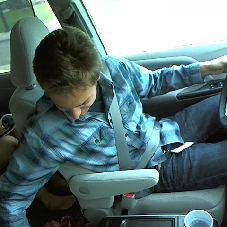

Class: 7


In [7]:
sample = 1
a = load_images_from_list(train_files, [sample], is_sample = True)
i = np.array(a[0])*255.0
i2 = i.transpose(1, 2, 0).astype(int)
img = Image.fromarray(i2.astype('uint8'))
display(img)
print("Class:",np.argmax(train_labels[sample]))

### Model definitions

In [8]:
# input: 28x28x1 filter: 5x5x1 num_filters: 6 stride: 1 output: 24x24x6
conv1 = behlul.Conv_Layer (28, 28, 1, 5, 1, 6)
# output: 24x24x6
relu1 = behlul.ReLU(24, 24, 6)
# input: 24x24x6 filter: 2x2x6 stride: 2 output: 12x12x6
pool1 =  behlul.Max_Pool(24, 24, 6, 2, 2)
# input: 12x12x6 filter: 5x5x6 num_filters: 16 stride: 1 output: 8x8x16
conv2 =  behlul.Conv_Layer(12, 12, 6, 5, 1, 16)
# output: 8x8x16
relu2 =  behlul.ReLU(8, 8, 16)
# input: 8x8x16 filter: 2x2x16 stride: 2 output: 4x4x16
pool2 =  behlul.Max_Pool(8, 8, 16, 2, 2)
# input: 4x4x16 output: 1x10
dense =  behlul.Dense_Layer(4, 4, 16, 10)
soft =  behlul.Softmax(0)
entropy =  behlul.Cross_Entropy(0)

In [9]:
TRAIN_DATA_SIZE = len(train_files)
VALID_DATA_SIZE = len(valid_files)
TEST_DATA_SIZE = len(test_files)
EPOCHS = 5
BATCH_SIZE = 10
BATCHES = TRAIN_DATA_SIZE / BATCH_SIZE;
LEARNING_RATE = 0.05;

### Run Full Training
[Skip](#Run-Test-set-with-Pretrained-weights) this part if you want to run with pretrained weights. Training takes ~6 mins per epoch. For 5 epochs, it takes ~30 mins.

In [10]:
train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
for epoch in range(EPOCHS):
    for b in range(int(BATCHES)):
        if b % 100 == 0:
            print("Epoch: ", epoch," Batch: ", b)
        batch = (np.random.rand(BATCH_SIZE)*(TRAIN_DATA_SIZE - 1)).astype(int)
        train_batch = load_images_from_list(train_files, batch)
        for idx, img in enumerate(train_batch):
            conv1.feed_forward(img)
            relu1.feed_forward(conv1.output)
            pool1.feed_forward(relu1.output)
            conv2.feed_forward(pool1.output)
            relu2.feed_forward(conv2.output)
            pool2.feed_forward(relu2.output)
            dense.feed_forward(pool2.output)
            dense_out = dense.output / 100
            soft.feed_forward(dense_out)
            entropy.feed_forward(soft.output, train_labels[batch[idx]])
            
            # Backward pass
            entropy.back_propagation()
            soft.back_propagation(entropy.gradients)
            dense.back_propagation(soft.gradients)
            pool2.back_propagation(dense.gradients)
            relu2.back_propagation(pool2.gradients)
            conv2.back_propagation(relu2.gradients)
            pool1.back_propagation(conv2.gradients)
            relu1.back_propagation(pool1.gradients)
            conv1.back_propagation(relu1.gradients)
        # Update params
        dense.update_weights(BATCH_SIZE, LEARNING_RATE)
        conv1.update_weights(BATCH_SIZE, LEARNING_RATE)
        conv2.update_weights(BATCH_SIZE, LEARNING_RATE)

    cumulative_loss = 0.0
    true_positive = 0.0
    for i in range(TRAIN_DATA_SIZE):
        if i % 1000 == 0:
            print("Training: ", i)
        img = load_images_from_list(train_files, [i])
        conv1.feed_forward(img[0])
        relu1.feed_forward(conv1.output)
        pool1.feed_forward(relu1.output)
        conv2.feed_forward(pool1.output)
        relu2.feed_forward(conv2.output)
        pool2.feed_forward(relu2.output)
        dense.feed_forward(pool2.output)
        dense_out = dense.output / 100
        soft.feed_forward(dense_out)
        entropy.feed_forward(soft.output, train_labels[i])
        cumulative_loss += entropy.loss
        
        actual_index = np.argmax(train_labels[i])
        pred_index = np.argmax(soft.output)
        if actual_index == pred_index:
            true_positive += 1.0
    print("true_positive: ", true_positive)
    print("Training accuracy: ", true_positive / TRAIN_DATA_SIZE)
    train_accuracy.append(true_positive / TRAIN_DATA_SIZE)
    train_loss.append(cumulative_loss / TRAIN_DATA_SIZE)
    
    cumulative_loss = 0.0
    true_positive = 0.0
    for i in range(VALID_DATA_SIZE):
        if i % 1000 == 0:
            print("Validating: ", i)
        img = load_images_from_list(valid_files, [i])
        conv1.feed_forward(img[0])
        relu1.feed_forward(conv1.output)
        pool1.feed_forward(relu1.output)
        conv2.feed_forward(pool1.output)
        relu2.feed_forward(conv2.output)
        pool2.feed_forward(relu2.output)
        dense.feed_forward(pool2.output)
        dense_out = dense.output / 100
        soft.feed_forward(dense_out)
        entropy.feed_forward(soft.output, valid_labels[i])
        cumulative_loss += entropy.loss
        
        actual_index = np.argmax(valid_labels[i])
        pred_index = np.argmax(soft.output)
        if actual_index == pred_index:
            true_positive += 1.0
    print("true_positive: ", true_positive)
    print("Validation accuracy: ", true_positive / VALID_DATA_SIZE)
    valid_accuracy.append(true_positive / VALID_DATA_SIZE)
    valid_loss.append(cumulative_loss / VALID_DATA_SIZE)

Epoch:  0  Batch:  0
Epoch:  0  Batch:  100
Epoch:  0  Batch:  200
Epoch:  0  Batch:  300
Epoch:  0  Batch:  400
Epoch:  0  Batch:  500
Epoch:  0  Batch:  600
Epoch:  0  Batch:  700
Epoch:  0  Batch:  800
Epoch:  0  Batch:  900
Epoch:  0  Batch:  1000
Epoch:  0  Batch:  1100
Epoch:  0  Batch:  1200
Epoch:  0  Batch:  1300
Epoch:  0  Batch:  1400
Epoch:  0  Batch:  1500
Epoch:  0  Batch:  1600
Epoch:  0  Batch:  1700
Training:  0
Training:  1000
Training:  2000
Training:  3000
Training:  4000
Training:  5000
Training:  6000
Training:  7000
Training:  8000
Training:  9000
Training:  10000
Training:  11000
Training:  12000
Training:  13000
Training:  14000
Training:  15000
Training:  16000
Training:  17000
true_positive:  12145.0
Training accuracy:  0.6747222222222222
Validating:  0
Validating:  1000
true_positive:  1324.0
Validation accuracy:  0.662
Epoch:  1  Batch:  0
Epoch:  1  Batch:  100
Epoch:  1  Batch:  200
Epoch:  1  Batch:  300
Epoch:  1  Batch:  400
Epoch:  1  Batch:  500
Epoc

Plot average losses for both train and validation data.

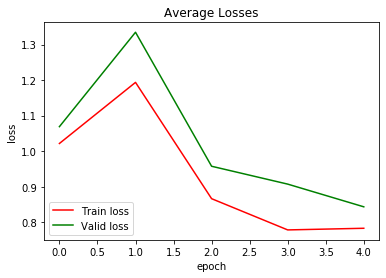

In [11]:
plt.plot(train_loss, color="red", label="Train loss")
plt.plot(valid_loss, color="green", label="Valid loss")
plt.legend(loc='lower left')
plt.title("Average Losses")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

Plot both train and validation accuracies.

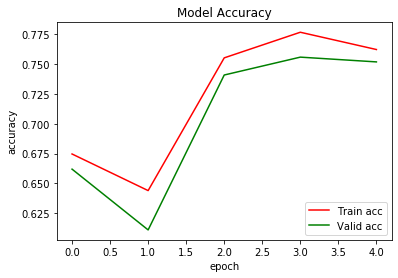

In [12]:
plt.plot(train_accuracy, color="red", label="Train acc")
plt.plot(valid_accuracy, color="green", label="Valid acc")
plt.legend(loc='lower right')
plt.title("Model Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

### Test
It takes around ~secs.

In [13]:
true_positive = 0.0
print("TEST_DATA_SIZE:", TEST_DATA_SIZE)
for i in range(TEST_DATA_SIZE):
    if i % 1000 == 0:
        print("Testing: ", i)
    img = load_images_from_list(test_files, [i])
    conv1.feed_forward(img[0])
    relu1.feed_forward(conv1.output)
    pool1.feed_forward(relu1.output)
    conv2.feed_forward(pool1.output)
    relu2.feed_forward(conv2.output)
    pool2.feed_forward(relu2.output)
    dense.feed_forward(pool2.output)
    dense_out = dense.output / 100
    soft.feed_forward(dense_out)

    actual_index = np.argmax(test_labels[i])
    pred_index = np.argmax(soft.output)
    if actual_index == pred_index:
        true_positive += 1.0
print("true_positive: ", true_positive)
print("Testing accuracy: ", true_positive / TEST_DATA_SIZE)

TEST_DATA_SIZE: 2424
Testing:  0
Testing:  1000
Testing:  2000
true_positive:  1774.0
Testing accuracy:  0.7318481848184818


In [ ]:
conv1.save_filters("data/state_conv1.out")
conv2.save_filters("data/state_conv2.out")
dense.save_weights("data/state_dense.out")

### Run Test set with Pretrained weights
It takes ~10 secs.

In [14]:
conv1.load_filters("data/state_conv1.out")
conv2.load_filters("data/state_conv2.out")
dense.load_weights("data/state_dense.out")

In [15]:
true_positive = 0.0
print("TEST_DATA_SIZE:", TEST_DATA_SIZE)
for i in range(TEST_DATA_SIZE):
    if i % 1000 == 0:
        print("Testing: ", i)
    img = load_images_from_list(test_files, [i])
    conv1.feed_forward(img[0])
    relu1.feed_forward(conv1.output)
    pool1.feed_forward(relu1.output)
    conv2.feed_forward(pool1.output)
    relu2.feed_forward(conv2.output)
    pool2.feed_forward(relu2.output)
    dense.feed_forward(pool2.output)
    dense_out = dense.output / 100
    soft.feed_forward(dense_out)

    actual_index = np.argmax(test_labels[i])
    pred_index = np.argmax(soft.output)
    if actual_index == pred_index:
        true_positive += 1.0
print("true_positive: ", true_positive)
print("Testing accuracy: ", true_positive / TEST_DATA_SIZE)

TEST_DATA_SIZE: 2424
Testing:  0
Testing:  1000
Testing:  2000
true_positive:  1790.0
Testing accuracy:  0.7384488448844885
